# SASA Analysis - Lourdes 

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
#from scipy.stats import gaussian_kde
from Bio.SeqUtils import IUPACData
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing
from itertools import product
import statistics
from statistics import mean, median, mode, stdev

In [2]:
def read_trajectory (dirname, equil=0, temp=1):
    #Read the trajectory and save it 
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    return t

def helicity (t):
    ss = md.compute_dssp(t,simplified=True)
    ssh = (ss=='H').astype(np.float)
    ssc = (ss=='C').astype(np.float)
    t_helix = t[np.all(ssh[:,6:10]>0,1)]
    return t_helix

def distance_thelix (t_helix):
    t_helix_d = t_helix[::100]
    return t_helix_d

def distance_hbond (t_helix_d):#
    #Calculate the distance between the Q1 (sc) and L1 (mc)
    #These are the potential donor atom names.
    #Selecting the hydrogens of Q1
    donors_helix = t_helix_d.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors_helix.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix = t_helix_d.topology.select('residue 7 and name O')
    pairs_helix = list(product(donors_helix, acceptor_helix))
    try:
        d_helix = md.compute_distances(t_helix_d, pairs_helix)
        #We take the shortest distance
        d_helix = d_helix.min(1)
        d_helix *= 10 #to angstroms
    except:
        d_helix = [0]*(int(len(t_helix_d)))
    return d_helix

def distance_O (t_helix_d):
    mcO = t_helix_d.topology.select('residue 7 and name O')
    scO = t_helix_d.topology.select('residue 11 and name CD')
    pairO = list(product(mcO,scO))
    d_O = md.compute_distances(t_helix_d,pairO)
    d_O *= 10
    return d_O

def freq_hbond (t_helix):#me devuelve un solo valor
    #Calculate the distance between the Q1 (sc) and L1 (mc)
    #These are the potential donor atom names.
    #Selecting the hydrogens of Q1
    donors_helix = t_helix.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors_helix.size==0: 
        np.array([9999.])
    #Selecting the oxigen of L1
    acceptor_helix = t_helix.topology.select('residue 7 and name O')
    pairs_helix = list(product(donors_helix, acceptor_helix))
    try:
        d_helix = md.compute_distances(t_helix, pairs_helix)
        #We take the shortest distance
        d_helix = d_helix.min(1)
        d_helix *= 10 #to angstroms
        t_hhbond = t_helix[d_helix<2.4]
        frequency_hbond = len(t_hhbond)/len(t_helix)
    except:
        frequency_hbond = 0
    return frequency_hbond

def select_index (t_helix):
    try:
        Q1sc_index = t_helix.topology.select('residue 11 and name HE21 HE2')
        Q1mc_index = t_helix.topology.select('residue 11 and name H')
        L1_index = t_helix.topology.select('residue 7 and name O')
        return Q1sc_index, Q1mc_index, L1_index
    except:
        pass
    
def mean_sasa (t_helix, Q1sc_index, Q1mc_index, L1_index):
    #this function gets the mean for the SASA 
    sasa = md.shrake_rupley(t_helix, mode='atom')
    # sc Hydrogen Q1/E1 sasa
    if Q1sc_index.size > 0:
        Q1sc = sasa[:,Q1sc_index]
        Q1sc = mean (Q1sc[:,0])
    else:
        Q1sc = 0
    # mc Hydrogen Q1/E1 sasa
    Q1mc = sasa[:,Q1mc_index]
    Q1mc = mean (Q1mc[:,0])
    # mc Oxigen L1 sasa
    L1 = sasa[:,L1_index]
    L1 = mean (L1[:,0])
    return Q1sc, Q1mc, L1

def sasa_frames (t_helix_d, Q1sc_index, Q1mc_index, L1_index):
    #this function gets ALL THE VALUES for SASA 
    sasa_F = md.shrake_rupley(t_helix_d, mode='atom')
    Q1Hmc = sasa_F[:,Q1mc_index]
    Q1Hmc= list(Q1Hmc)
    L1O = sasa_F[:,L1_index]
    L1O=list(L1O)
    if Q1sc_index.size >= 1:
        Q1Hsc = sasa_F[:,Q1sc_index]
        Q1Hsc=list(Q1Hsc)
    else:
        Q1Hsc = np.zeros_like(L1O)
    return Q1Hsc, Q1Hmc, L1O
    
    

In [3]:
system_list = ('L4_Q12_DES-amber','A4_Q12_DES-amber','Q1EH_DES-amber','Q1E_DES-amber')

t={}
t_helix={}
t_helix_d={}
Q1sc_index={}
Q1mc_index={}
L1_index={}
frequency_hbond={}
#mean SASA
Q1sc={}
Q1mc={}
L1={}
#frame SASA
Q1Hsc={}
Q1Hmc={}
L1O={}
distance={}
d_O={}

for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    #first we have to read the trajectories 
    t[system] = read_trajectory(path, equil=0)
    print (system)
    #then we have to choose only the helical frames 
    t_helix[system] = helicity(t[system])
    t_helix_d[system] = distance_thelix(t_helix[system])
    print (t_helix[system])
    print(t_helix_d[system])
    #calculate the hydrogen bond frequency 
    frequency_hbond[system] = freq_hbond (t_helix[system])
    print(frequency_hbond[system])
    #we have to calculate the distances 1-between the mc oxygen and the sc hydrogen
    distance[system] = distance_hbond(t_helix_d[system])
    print(distance[system])
    # and 2- between the mc oxygen (L/A) and sc carbonyl group (Q/E)
    d_O[system] = distance_O(t_helix_d[system])
    print(d_O[system])
    #we select the trajectory of only the atoms we are interested in, which are the sc Hydrogen, the mc Hydrogen and the mc Oxygen 
    Q1sc_index[system],Q1mc_index[system],L1_index[system] = select_index(t_helix[system])
    print(Q1sc_index[system],Q1mc_index[system],L1_index[system])
    #We calculate the sasa for every 1000 frames of all the trajectories for the selected atoms 
    Q1Hsc[system], Q1Hmc[system], L1O[system] = sasa_frames(t_helix_d[system],Q1sc_index[system],Q1mc_index[system],L1_index[system])
    print (Q1Hsc[system], Q1Hmc[system], L1O[system])
    # we can also measure the correlation between the SASA and the frequency of the hbond, for that, we need the SASA mean for
    # the atom of interest for each helical trajectory 
    Q1sc[system],Q1mc[system],L1[system] = mean_sasa(t_helix[system],Q1sc_index[system], Q1mc_index[system], L1_index[system])
    print (system,Q1sc[system],Q1mc[system],L1[system])
  


L4_Q12_DES-amber
<mdtraj.Trajectory with 11439 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 115 frames, 413 atoms, 24 residues, and unitcells>
0.057435090479937057
[5.423319  4.605277  4.4224315 4.808044  3.9926183 6.6399183 6.988312
 6.847517  4.4284887 4.8628583 6.2707353 4.421198  4.8223743 7.0242267
 5.631824  7.039155  5.075756  5.15502   5.855628  4.702274  6.031342
 4.8406706 7.0588546 5.304508  6.912851  7.6315403 5.0477834 6.8131714
 7.132282  5.650787  6.7148867 5.942171  4.606886  5.9525304 4.071521
 3.9759018 3.1780047 5.5985985 4.5147104 5.1885467 4.7253075 7.323234
 7.0868964 6.617265  4.47416   4.6476984 4.3607464 7.3913736 5.780739
 5.7734394 6.99772   4.7584043 7.1353273 5.032007  6.9480486 7.4575753
 6.320987  4.335352  4.937641  4.0070195 4.4685907 7.4941387 5.29344
 7.264138  5.099618  5.4635077 6.2731237 4.8853235 1.9601295 7.492529
 7.00572   3.9590135 4.541915  4.719535  6.8509417 1.9444538 2.6914864
 5.466022  5.98177   3.9835408 6.7867

L4_Q12_DES-amber 0.13559142 0.00011667961 0.013247123
A4_Q12_DES-amber
<mdtraj.Trajectory with 5339 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 54 frames, 377 atoms, 24 residues, and unitcells>
0.01760629331335456
[5.2356095 2.9543352 7.5594754 4.9766045 5.986877  4.797048  6.0525856
 4.774862  7.607562  5.042679  5.9079103 3.849403  5.816435  7.2816133
 7.2301383 7.2630568 4.677617  3.8095932 6.8481045 3.9927695 5.9696393
 4.527692  7.476162  7.523051  6.7601247 7.055288  5.288639  6.597439
 6.939871  7.0598435 7.266014  6.5215044 6.464882  6.1062107 7.0826406
 6.3660727 7.044815  5.295101  2.3966038 7.3743773 4.8152056 7.440881
 7.0037575 7.55643   5.17496   3.3499405 5.5840063 7.6332564 4.882131
 6.2137437 7.975833  7.086643  7.327443  5.106634 ]
[[3.769058 ]
 [4.18999  ]
 [6.0530305]
 [5.0935464]
 [5.694258 ]
 [4.6342278]
 [4.502277 ]
 [5.2921457]
 [5.9797916]
 [4.403202 ]
 [5.394376 ]
 [3.8086877]
 [5.467022 ]
 [5.8187795]
 [5.4750867]
 [5.7571955]
 [3.7

[array([0.12299858], dtype=float32), array([0.2027468], dtype=float32), array([0.15945815], dtype=float32), array([0.18685117], dtype=float32), array([0.19572425], dtype=float32), array([0.17803445], dtype=float32), array([0.11076777], dtype=float32), array([0.16468604], dtype=float32), array([0.12225943], dtype=float32), array([0.16646597], dtype=float32), array([0.12580054], dtype=float32), array([0.09213904], dtype=float32), array([0.11246153], dtype=float32), array([0.09999165], dtype=float32), array([0.09565572], dtype=float32), array([0.2363481], dtype=float32), array([0.17453086], dtype=float32), array([0.14615995], dtype=float32), array([0.09658147], dtype=float32), array([0.1744072], dtype=float32), array([0.15146913], dtype=float32), array([0.14171514], dtype=float32), array([0.11162052], dtype=float32), array([0.13371593], dtype=float32), array([0.18240398], dtype=float32), array([0.14439715], dtype=float32), array([0.13096252], dtype=float32), array([0.17886204], dtype=floa

Q1EH_DES-amber 0.13692947 5.686823e-05 0.008084687
Q1E_DES-amber
<mdtraj.Trajectory with 6118 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 62 frames, 411 atoms, 24 residues, and unitcells>
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[4.118554 ]
 [4.777637 ]
 [5.2372303]
 [4.088397 ]
 [5.855946 ]
 [5.6916246]
 [7.3264093]
 [3.953999 ]
 [6.0727763]
 [6.0223913]
 [4.8802986]
 [5.527792 ]
 [5.5374475]
 [5.3516726]
 [5.62787  ]
 [4.830333 ]
 [4.835638 ]
 [8.0265875]
 [5.856157 ]
 [5.1014614]
 [5.588746 ]
 [5.2926807]
 [4.9099674]
 [5.687742 ]
 [5.276393 ]
 [5.5539713]
 [5.5679445]
 [4.703042 ]
 [4.2395396]
 [6.1147456]
 [4.96245  ]
 [5.714175 ]
 [5.8862057]
 [5.484207 ]
 [5.7425604]
 [5.8797035]
 [5.952992 ]
 [6.1317134]
 [7.269231 ]
 [5.4056544]
 [5.575061 ]
 [5.6641436]
 [6.035413 ]
 [6.120115 ]
 [4.5954432]
 [5.675887 

<ipython-input-24-41cdaa19e18e>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


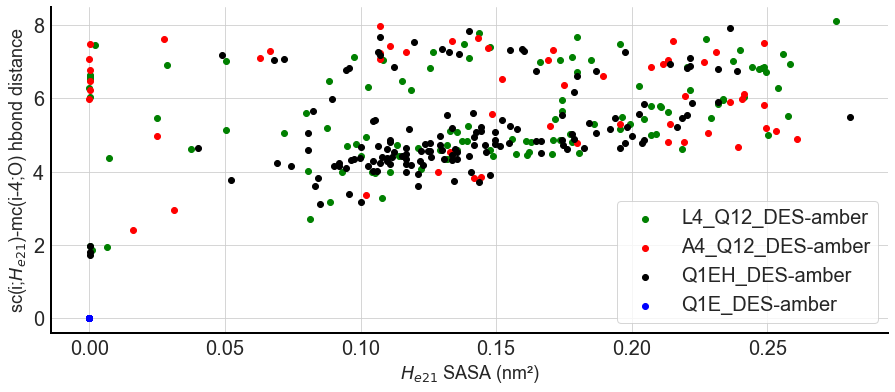

In [24]:
fig = plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
#plt.suptitle('SASA correlation with sc(i;H)-mc(i-4;O) hbond distance ', fontsize=22)

plt.scatter(Q1Hsc['L4_Q12_DES-amber'], distance['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(Q1Hsc['A4_Q12_DES-amber'], distance['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(Q1Hsc['Q1EH_DES-amber'], distance['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(Q1Hsc['Q1E_DES-amber'], distance['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('sc(i;$H_{e21}$)-mc(i-4;O) hbond distance', size=18)
plt.xlabel('$H_{e21}$ SASA (nm²)', size=18)
plt.legend(fontsize=20)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)

fig.savefig(f"/home/lourdes/Documents/SASA_He21_DES-amber.png")

<ipython-input-10-9177f93bec3b>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


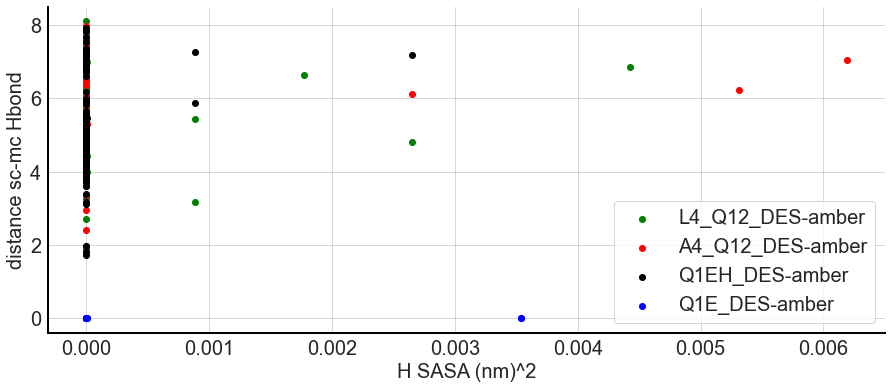

In [10]:
fig = plt.figure(figsize=(15,6))
plt.scatter(Q1Hmc['L4_Q12_DES-amber'], distance['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(Q1Hmc['A4_Q12_DES-amber'], distance['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(Q1Hmc['Q1EH_DES-amber'], distance['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(Q1Hmc['Q1E_DES-amber'], distance['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('sc(i;H)-mc(i-4;O) hbond distance', size=20)
plt.xlabel('H SASA (nm²)', size=20)
plt.legend(fontsize=20)
ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)

<ipython-input-23-6eeb89fd35ea>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


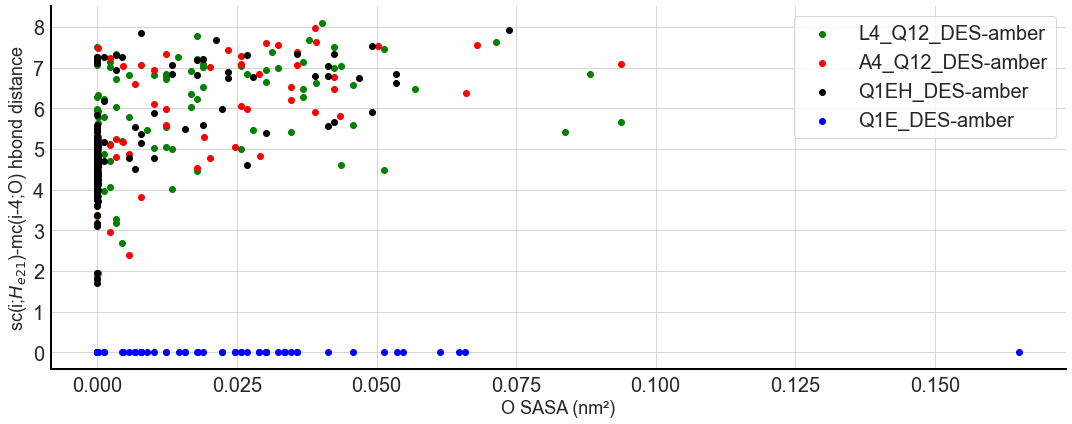

In [23]:
fig = plt.figure(figsize=(15,6))
plt.scatter(L1O['L4_Q12_DES-amber'], distance['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(L1O['A4_Q12_DES-amber'], distance['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(L1O['Q1EH_DES-amber'], distance['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(L1O['Q1E_DES-amber'], distance['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('sc(i;$H_{e21}$)-mc(i-4;O) hbond distance', size=18)
plt.xlabel('O SASA (nm²)', size=18)
plt.legend(fontsize=20)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)

fig.tight_layout()

fig.savefig(f"/home/lourdes/Documents/SASA_O_DES-amber.png")

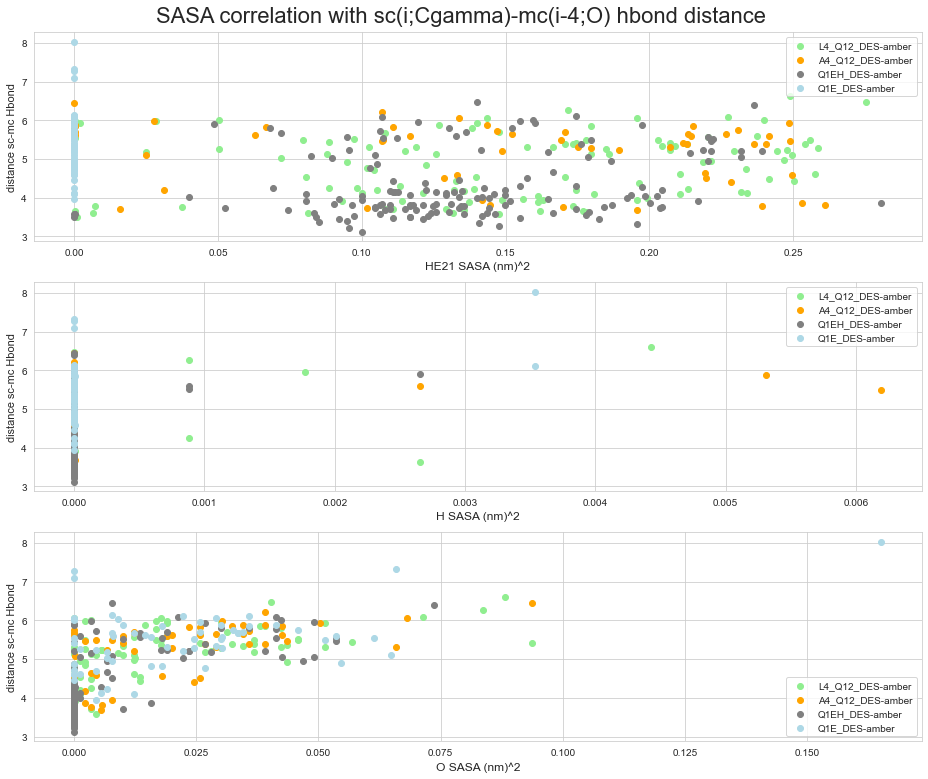

In [29]:
fig = plt.figure(figsize=(13,11))
sns.set_style('whitegrid')
plt.suptitle('SASA correlation with sc(i;Cgamma)-mc(i-4;O) hbond distance ', fontsize=22)

plt.subplot(311)
plt.scatter(Q1Hsc['L4_Q12_DES-amber'], d_O['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='lightgreen')
plt.scatter(Q1Hsc['A4_Q12_DES-amber'], d_O['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='orange')
plt.scatter(Q1Hsc['Q1EH_DES-amber'], d_O['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='grey')
plt.scatter(Q1Hsc['Q1E_DES-amber'], d_O['Q1E_DES-amber'], label='Q1E_DES-amber', color='lightblue')
plt.ylabel('distance sc-mc Hbond', size=11)
plt.xlabel('HE21 SASA (nm)^2', size=12)
plt.legend()

plt.subplot(312)
plt.scatter(Q1Hmc['L4_Q12_DES-amber'], d_O['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='lightgreen')
plt.scatter(Q1Hmc['A4_Q12_DES-amber'], d_O['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='orange')
plt.scatter(Q1Hmc['Q1EH_DES-amber'], d_O['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='grey')
plt.scatter(Q1Hmc['Q1E_DES-amber'], d_O['Q1E_DES-amber'], label='Q1E_DES-amber', color='lightblue')
plt.ylabel('distance sc-mc Hbond', size=11)
plt.xlabel('H SASA (nm)^2', size=12)
plt.legend()

plt.subplot(313)
plt.scatter(L1O['L4_Q12_DES-amber'], d_O['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='lightgreen')
plt.scatter(L1O['A4_Q12_DES-amber'], d_O['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='orange')
plt.scatter(L1O['Q1EH_DES-amber'], d_O['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='grey')
plt.scatter(L1O['Q1E_DES-amber'], d_O['Q1E_DES-amber'], label='Q1E_DES-amber', color='lightblue')
plt.ylabel('distance sc-mc Hbond', size=11)
plt.xlabel('O SASA (nm)^2', size=12)
plt.legend()


fig.tight_layout()

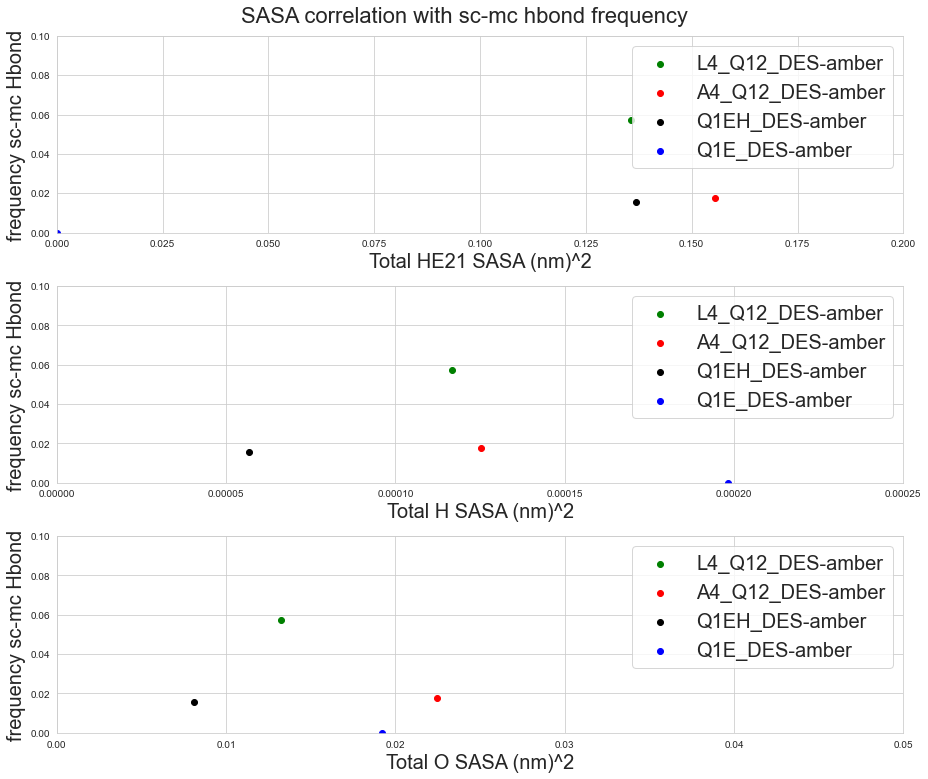

In [15]:
fig = plt.figure(figsize=(13,11))
sns.set_style('whitegrid')
plt.suptitle('SASA correlation with sc-mc hbond frequency', fontsize=22)

plt.subplot(311)
plt.scatter(Q1sc['L4_Q12_DES-amber'], frequency_hbond['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(Q1sc['A4_Q12_DES-amber'], frequency_hbond['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(Q1sc['Q1EH_DES-amber'], frequency_hbond['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(Q1sc['Q1E_DES-amber'], frequency_hbond['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('frequency sc-mc Hbond', size=20)
plt.xlabel('Total HE21 SASA (nm)^2', size=20)
plt.xlim(0.0,0.20)
plt.ylim(0,0.1)
plt.legend(fontsize=20)

plt.subplot(312)
plt.scatter(Q1mc['L4_Q12_DES-amber'], frequency_hbond['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(Q1mc['A4_Q12_DES-amber'], frequency_hbond['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(Q1mc['Q1EH_DES-amber'], frequency_hbond['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(Q1mc['Q1E_DES-amber'], frequency_hbond['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('frequency sc-mc Hbond', size=20)
plt.xlabel('Total H SASA (nm)^2', size=20)
plt.xlim(0.0,0.00025)
plt.ylim(0,0.1)
plt.legend(fontsize=20)

plt.subplot(313)
plt.scatter(L1['L4_Q12_DES-amber'], frequency_hbond['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', color='green')
plt.scatter(L1['A4_Q12_DES-amber'], frequency_hbond['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', color='red')
plt.scatter(L1['Q1EH_DES-amber'], frequency_hbond['Q1EH_DES-amber'], label='Q1EH_DES-amber', color='black')
plt.scatter(L1['Q1E_DES-amber'], frequency_hbond['Q1E_DES-amber'], label='Q1E_DES-amber', color='blue')
plt.ylabel('frequency sc-mc Hbond', fontsize=20)
plt.xlabel('Total O SASA (nm)^2', fontsize=20)
plt.xlim(0.0,0.050)
plt.ylim(0,0.1)
plt.legend(fontsize=20)



fig.tight_layout()